# 0. Prepare data


### 0.1 Define functions

#### 0.1.1 Function to load data

In [65]:
import json
import pickle
import numpy as np

from sklearn.feature_extraction import DictVectorizer

def load_X(dataset_path, reduced=False):
    print("Loading data (feature representation X, and feature names)...")
    # Load the reduced 10k features
    if reduced:
        with open('{}/X-10k.p'.format(dataset_path), 'rb') as f:
            X = pickle.load(f)
        with open('{}/f-10k.p'.format(dataset_path), 'rb') as f:
            feature_names = pickle.load(f)
    else:
        with open('{}/X.json'.format(dataset_path), 'r') as f:
            X = json.load(f)

        # Convert to numpy array and get feature names
        vec = DictVectorizer()
        X = vec.fit_transform(X).astype("float32")
        feature_names = vec.get_feature_names_out()

    return X, feature_names


def load_y(dataset_path):
    print('Loading labels...')
    with open('{}y.json'.format(dataset_path), 'rt') as f:
        y = json.load(f)
    y = np.asarray(y)
    return y

def load_metadata(dataset_path):
    print('Loading metadata...')
    with open('{}meta.json'.format(dataset_path), 'rt') as f:
        metadata = json.load(f)
    return metadata

In [66]:
# Set the path to the dataset
dataset_path = './extended-features/'

# Load the data
X, feature_names = load_X(dataset_path, reduced=False)
y = load_y(dataset_path)
metadata = load_metadata(dataset_path)

## Print the shape of the data (loaded from the dataset)
print(f"\n - X Shape: {X.shape}")
print(f" - y Shape: {y.shape}")
print(f" - Metadata: {len(metadata)}")

Loading data (feature representation X, and feature names)...
Loading labels...
Loading metadata...

 - X Shape: (259230, 2657297)
 - y Shape: (259230,)
 - Metadata: 259230


In [67]:
from datetime import datetime

import numpy as np

def get_quarter(date_string):
    try:
        # Try the format with 'T' first
        date = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S')
    except ValueError:
        # If it fails, try the format with a space
        date = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    return f"{date.year}-Q{(date.month-1)//3 + 1}"
# Select features that start with 'api_calls::'
interest = "api_calls::"
selected_indices = [
    i
    for i, feature_name in enumerate(feature_names)
    if feature_name.startswith(interest)
]

# Count the number of 'api_calls::' features for each sample
api_call_counts = np.sum(X[:, selected_indices] > 0, axis=1)

# Combine the counts with the labels and add an index
combined_api_data = []
for idx, (meta, count, label) in enumerate(zip(metadata, api_call_counts, y)):
    dex_date = meta['dex_date']
    quarter = get_quarter(dex_date)
    category = 'benign' if label == 0 else 'malicious'
    combined_api_data.append({
        'index': idx,
        'dex_date': dex_date,
        'quarter': quarter,
        'api_call_count': int(count),
        'category': category,
    })

/var/folders/kh/_kvrqy8j0yq7sjnzmxrljggm0000gn/T/ipykernel_16093/1133543688.py:34: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [68]:
# Count occurrences for each quarter and category
from collections import defaultdict

quarterly_counts = defaultdict(lambda: {'benign': 0, 'malicious': 0})

for entry in combined_api_data:
    quarterly_counts[entry['quarter']][entry['category']] += 1

# Print the counts
print("Quarterly counts:")
for quarter, counts in sorted(quarterly_counts.items()):
    print(f"{quarter}: Benign: {counts['benign']}, Malicious: {counts['malicious']}")

# Additional statistics
total_samples = len(combined_api_data)
total_benign = sum(counts['benign'] for counts in quarterly_counts.values())
total_malicious = sum(counts['malicious'] for counts in quarterly_counts.values())

print(f"\nTotal samples: {total_samples}")
print(f"Total benign: {total_benign} ({total_benign/total_samples*100:.2f}%)")
print(f"Total malicious: {total_malicious} ({total_malicious/total_samples*100:.2f}%)")

Quarterly counts:
2014-Q1: Benign: 9992, Malicious: 1026
2014-Q2: Benign: 15246, Malicious: 1818
2014-Q3: Benign: 17708, Malicious: 1970
2014-Q4: Benign: 9097, Malicious: 883
2015-Q1: Benign: 4683, Malicious: 488
2015-Q2: Benign: 5889, Malicious: 620
2015-Q3: Benign: 8365, Malicious: 901
2015-Q4: Benign: 9231, Malicious: 1056
2016-Q1: Benign: 13255, Malicious: 1455
2016-Q2: Benign: 13226, Malicious: 1342
2016-Q3: Benign: 9286, Malicious: 1064
2016-Q4: Benign: 1015, Malicious: 112
2017-Q1: Benign: 15000, Malicious: 1800
2017-Q2: Benign: 15000, Malicious: 1800
2017-Q3: Benign: 15000, Malicious: 1800
2017-Q4: Benign: 15000, Malicious: 1800
2018-Q1: Benign: 15000, Malicious: 1800
2018-Q2: Benign: 15000, Malicious: 1800
2018-Q3: Benign: 15000, Malicious: 1800
2018-Q4: Benign: 10850, Malicious: 1052

Total samples: 259230
Total benign: 232843 (89.82%)
Total malicious: 26387 (10.18%)


In [69]:
# Print a few examples of the combined data
print("\nSample of combined data with API call counts:")
for entry in combined_api_data[:5]:
    print(entry)
# You can also create a DataFrame for further analysis
import pandas as pd

df = pd.DataFrame(combined_api_data)
print("\nDataFrame with API call counts and categories:")
print(df.head())


Sample of combined data with API call counts:
{'index': 0, 'dex_date': '2016-04-05T17:58:46', 'quarter': '2016-Q2', 'api_call_count': 19, 'category': 'benign'}
{'index': 1, 'dex_date': '2016-01-19T13:28:36', 'quarter': '2016-Q1', 'api_call_count': 10, 'category': 'benign'}
{'index': 2, 'dex_date': '2016-01-02T23:48:34', 'quarter': '2016-Q1', 'api_call_count': 11, 'category': 'benign'}
{'index': 3, 'dex_date': '2014-09-01T15:34:38', 'quarter': '2014-Q3', 'api_call_count': 6, 'category': 'benign'}
{'index': 4, 'dex_date': '2016-05-03T17:25:52', 'quarter': '2016-Q2', 'api_call_count': 7, 'category': 'benign'}

DataFrame with API call counts and categories:
   index             dex_date  quarter  api_call_count category
0      0  2016-04-05T17:58:46  2016-Q2              19   benign
1      1  2016-01-19T13:28:36  2016-Q1              10   benign
2      2  2016-01-02T23:48:34  2016-Q1              11   benign
3      3  2014-09-01T15:34:38  2014-Q3               6   benign
4      4  2016-05

/var/folders/kh/_kvrqy8j0yq7sjnzmxrljggm0000gn/T/ipykernel_16093/3141376927.py:51: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



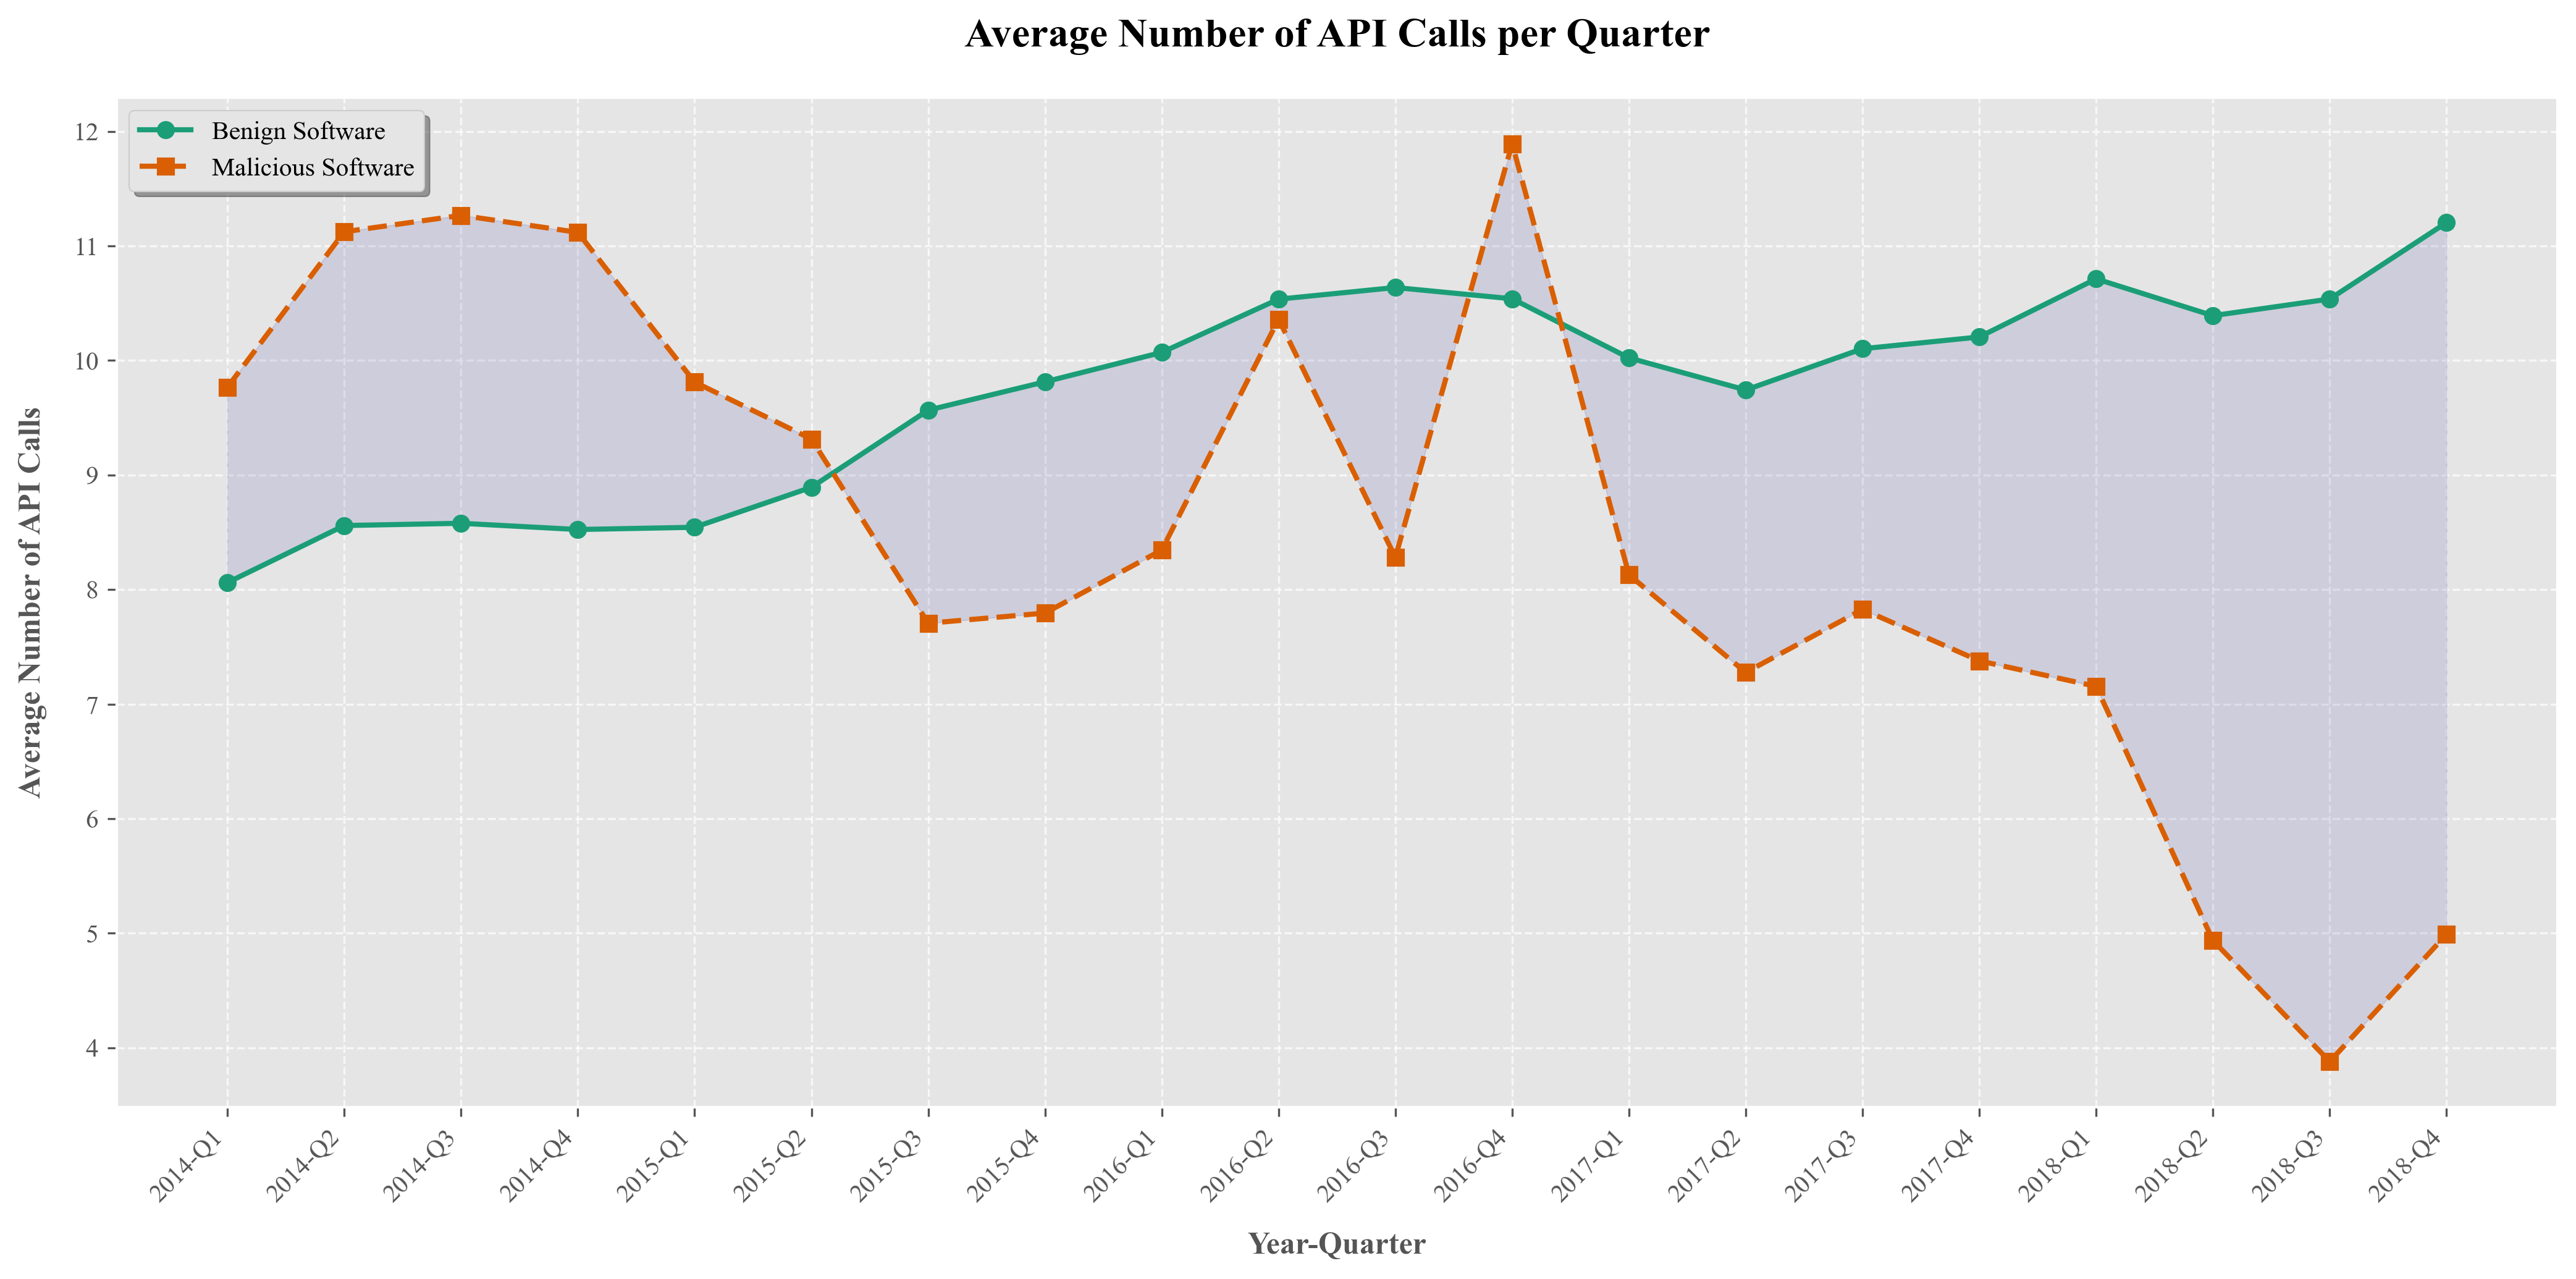

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the average number of API calls per quarter and category
quarterly_api_calls = defaultdict(lambda: {'benign': [], 'malicious': []})
for entry in combined_api_data:
    quarterly_api_calls[entry['quarter']][entry['category']].append(entry['api_call_count'])

# Calculate the average number of API calls per quarter and category
average_api_calls = {
    quarter: {
        'benign': np.mean(values['benign']) if values['benign'] else 0,
        'malicious': np.mean(values['malicious']) if values['malicious'] else 0
    }
    for quarter, values in quarterly_api_calls.items()
}
# Sort the quarters
quarters = sorted(average_api_calls.keys())

# Assuming you have the data in the same format as before
df = pd.DataFrame(average_api_calls.items(), columns=['Quarter', 'Values'])
df['Benign'] = df['Values'].apply(lambda x: x['benign'])
df['Malicious'] = df['Values'].apply(lambda x: x['malicious'])
df = df.sort_values('Quarter')

# Create a categorical x-axis
df['Quarter_Cat'] = pd.Categorical(df['Quarter'], categories=df['Quarter'], ordered=True)

# Set up the plot style
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

# Plot the data
ax.plot(df['Quarter_Cat'], df['Benign'], color='#1b9e77', linewidth=2, marker='o', markersize=6, label='Benign Software')
ax.plot(df['Quarter_Cat'], df['Malicious'], color='#d95f02', linewidth=2, marker='s', markersize=6, label='Malicious Software', linestyle='--')

# Fill the area between the lines
ax.fill_between(df['Quarter_Cat'], df['Benign'], df['Malicious'], alpha=0.2, color='#7570b3')

# Customize the plot
ax.set_title('Average Number of API Calls per Quarter', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Year-Quarter', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Average Number of API Calls', fontsize=12, fontweight='bold', labelpad=10)

# Format x-axis
plt.xticks(rotation=45, ha='right')
ax.set_xticklabels(df['Quarter'])

# Ensure all x-ticks are visible
ax.set_xticks(range(len(df['Quarter'])))

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add legend
ax.legend(frameon=True, fancybox=True, shadow=True, fontsize=10, loc='upper left')

# Tight layout
plt.tight_layout()

# Save the figure (uncomment to save)
# plt.savefig('api_calls_per_quarter.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.savefig('api_calls_per_quarter.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

#### 0.1.2 Function to train a model

##### 0.1.2.3 Calculate and Evaluation

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from collections import Counter

def print_data_info(X_train, X_test, y_train, y_test, model_name):
    print(f"\n📌 Training {model_name}")
    print(f"\t🔹 X_train shape: {X_train.shape}")
    print(f"\t🔹 X_test shape: {X_test.shape}")
    print(f"\t🔹 y_train distribution: {Counter(y_train)}")
    print(f"\t🔹 y_test distribution: {Counter(y_test)}\n")

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def calculate_metrics(y_test, predictions):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    return accuracy, precision, recall, f1

def print_metrics(model_name, accuracy, precision, recall, f1, cm, roc_auc, avg_precision):
    print(f"\n   ✅ {model_name} Evaluation Metrics:")
    print(f"\t🔹 Accuracy: {accuracy:.4f}")
    print(f"\t🔹 Precision: {precision:.4f}")
    print(f"\t🔹 Recall: {recall:.4f}")
    print(f"\t🔹 F1 Score: {f1:.4f}")
    print(f"\t🔹 ROC AUC: {roc_auc:.4f}")
    print(f"\t🔹 Average Precision: {avg_precision:.4f}")
    print("\n   ✅ Confusion Matrix:")
    print(f"\t🔹 TN: {cm[0, 0]}, FP: {cm[0, 1]}")
    print(f"\t🔹 FN: {cm[1, 0]}, TP: {cm[1, 1]}\n")

def calculate_roc_pr(y_test, y_scores):
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_scores)
    average_precision = average_precision_score(y_test, y_scores)
    return fpr, tpr, roc_auc, precision_curve, recall_curve, average_precision

##### 0.1.2.5 Plot Evaluation Results

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(model_name, fpr, tpr, roc_auc, precision_curve, recall_curve, average_precision, cm, coef=None, importances=None, feature_names=None):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle(f'{model_name} - Performance Evaluation', fontsize=16, weight='bold')
    
    # ROC Curve
    axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 0].set_xlim([0.0, 1.0])
    axes[0, 0].set_ylim([0.0, 1.05])
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0, 0].legend(loc="lower right")
    axes[0, 0].grid(True)
    
    # Precision-Recall Curve
    axes[0, 1].plot(recall_curve, precision_curve, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.4f})')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend(loc="lower left")
    axes[0, 1].grid(True)
    
    # Confusion Matrix
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=axes[1, 0])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[1, 0].text(j + 0.5, i + 0.5, f'{cm[i, j]}', 
                            horizontalalignment='center', 
                            verticalalignment='center', 
                            color='black', fontsize=12)
    axes[1, 0].set_xlabel('Predicted label')
    axes[1, 0].set_ylabel('True label')
    axes[1, 0].set_title('Confusion Matrix')
    
    # Feature Importance
    if coef is not None:
        # Feature Importance for Linear Models
        top_features = 20  # Show top 20 features
        # Get indices of the top positive and negative features
        top_positive_indices = np.argsort(coef)[-top_features:]
        top_negative_indices = np.argsort(coef)[:top_features]
        top_indices = np.hstack([top_negative_indices, top_positive_indices])
        
        axes[1, 1].bar(range(2 * top_features), coef[top_indices], color='r')
        axes[1, 1].set_xticks(range(2 * top_features))
        axes[1, 1].set_xticklabels(range(2 * top_features), rotation=90)
        axes[1, 1].set_xlabel('Features')
        axes[1, 1].set_ylabel('Coefficient Value')
        axes[1, 1].set_title('Top Positive and Negative Features')
    elif importances is not None and feature_names is not None:
        # Feature Importance for Tree-Based Models
        indices = np.argsort(importances)[-20:]  # Top 20 features
        axes[1, 1].barh(range(len(indices)), importances[indices], align='center')
        axes[1, 1].set_yticks(range(len(indices)))
        axes[1, 1].set_yticklabels([feature_names[i] for i in indices])
        axes[1, 1].invert_yaxis()
        axes[1, 1].set_xlabel('Feature Importance')
        axes[1, 1].set_title('Top 20 Important Features')
    else:
        axes[1, 1].text(0.5, 0.5, "Feature Importance not available for this model", 
                        ha='center', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

### 0.2 Define Classifier Models

In [61]:
from dataclasses import dataclass, field
from sklearn.metrics import confusion_matrix
from typing import Any
from sklearn.model_selection import TimeSeriesSplit


tscv = TimeSeriesSplit(n_splits=5)

@dataclass
class Model:
    name: str
    model: Any
    accuracy: float = field(init=False, default=None)
    precision: float = field(init=False, default=None)
    recall: float = field(init=False, default=None)
    f1: float = field(init=False, default=None)
    cm: np.ndarray = field(init=False, default=None)
    roc_auc: float = field(init=False, default=None)
    fpt: float = field(init=False, default=None)
    tpr: float = field(init=False, default=None)
    precision_curve: float = field(init=False, default=None)
    recall_curve: float = field(init=False, default=None)
    average_precision: float = field(init=False, default=None)
    cv_results: dict = field(init=False, default_factory=dict)

    def __str__(self):
        return self.name


    def train_and_evaluate_model(self, X_train, y_train, X_test, y_test):
        self.model.fit(X_train, y_train)

        predictions = self.model.predict(X_test)

        self.accuracy, self.precision, self.recall, self.f1 = calculate_metrics(y_test, predictions)
        self.cm = confusion_matrix(y_test, predictions)

        y_scores = self.get_prediction_scores(X_test)
        (
            self.fpr,
            self.tpr,
            self.roc_auc,
            self.precision_curve,
            self.recall_curve,
            self.average_precision,
        ) = calculate_roc_pr(y_test, y_scores)

    def get_prediction_scores(self, X_test):
        if hasattr(self.model, "predict_proba"):
            return self.model.predict_proba(X_test)[:, 1]
        elif hasattr(self.model, "decision_function"):
            return self.model.decision_function(X_test)
        else:
            raise AttributeError(
                "Model has neither predict_proba nor decision_function method"
            )

    def print_result(self):
        print_data_info(X_train, X_test, y_train, y_test, self.name)
        print_metrics(
            self.name,
            self.accuracy,
            self.precision,
            self.recall,
            self.f1,
            self.cm,
            self.roc_auc,
            self.average_precision,
        )
        plot_results(
            self.name,
            self.fpr,
            self.tpr,
            self.roc_auc,
            self.precision_curve,
            self.recall_curve,
            self.average_precision,
            self.cm,
            coef=None,
            importances=None,
            feature_names=None,
        )

In [62]:
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

## Parameters: XGBoost
xgb_parameters = {
    "n_estimators": 200,
    "learning_rate": 0.05,
    "max_depth": 4,
    "min_child_weight": 3,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "gamma": 0,
    "reg_alpha": 0.0,
    "reg_lambda": 1,
    "verbosity": 1,
}

## Parameters: Linear SVM
svm_parameters = {
    "C": 1,
    "dual": True,
    "max_iter": 50000,
    "random_state": 42,
}

def create_models(xgb_parameters, svm_parameters):
    models = [
        Model("XGBoost", XGBClassifier(**xgb_parameters)),
        Model("Linear SVM", LinearSVC(**svm_parameters)),
    ]
    return models

models = create_models(xgb_parameters, svm_parameters)

for model in models:
    print(f" - Model ({model.name}) created successfully")

 - Model (XGBoost) created successfully
 - Model (Linear SVM) created successfully


### 0.3 Prepare Dataset

#### 0.3.2 Split the data into training and testing sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # 80-20 split
)

print(f"\n - X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f" - X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")


 - X_train Shape: (207384, 2657297), y_train Shape: (207384,)
 - X_test Shape: (51846, 2657297), y_test Shape: (51846,)


# 1. Explore and evaluate different machine learning algorithms for Android malware detection

This suggests a comparative study of various ML algorithms to determine which are most effective for this specific application.

### Comparative Study of ML Algorithms

- Train various machine learning models like logistic regression, support vector machines, decision trees, random forests, gradient boosting machines, and neural networks on your dataset.
- Use cross-validation to evaluate their performance metrics (accuracy, precision, recall, F1 score, ROC-AUC, etc.).
- Perform statistical tests to determine if differences in performance are significant.

### 1.1 Config Parameters and Update models


📌 Training XGBoost
	🔹 X_train shape: (207384, 2657297)
	🔹 X_test shape: (51846, 2657297)
	🔹 y_train distribution: Counter({0: 186346, 1: 21038})
	🔹 y_test distribution: Counter({0: 46497, 1: 5349})


   ✅ XGBoost Evaluation Metrics:
	🔹 Accuracy: 0.9687
	🔹 Precision: 0.9146
	🔹 Recall: 0.7684
	🔹 F1 Score: 0.8351
	🔹 ROC AUC: 0.9797
	🔹 Average Precision: 0.9095

   ✅ Confusion Matrix:
	🔹 TN: 46113, FP: 384
	🔹 FN: 1239, TP: 4110



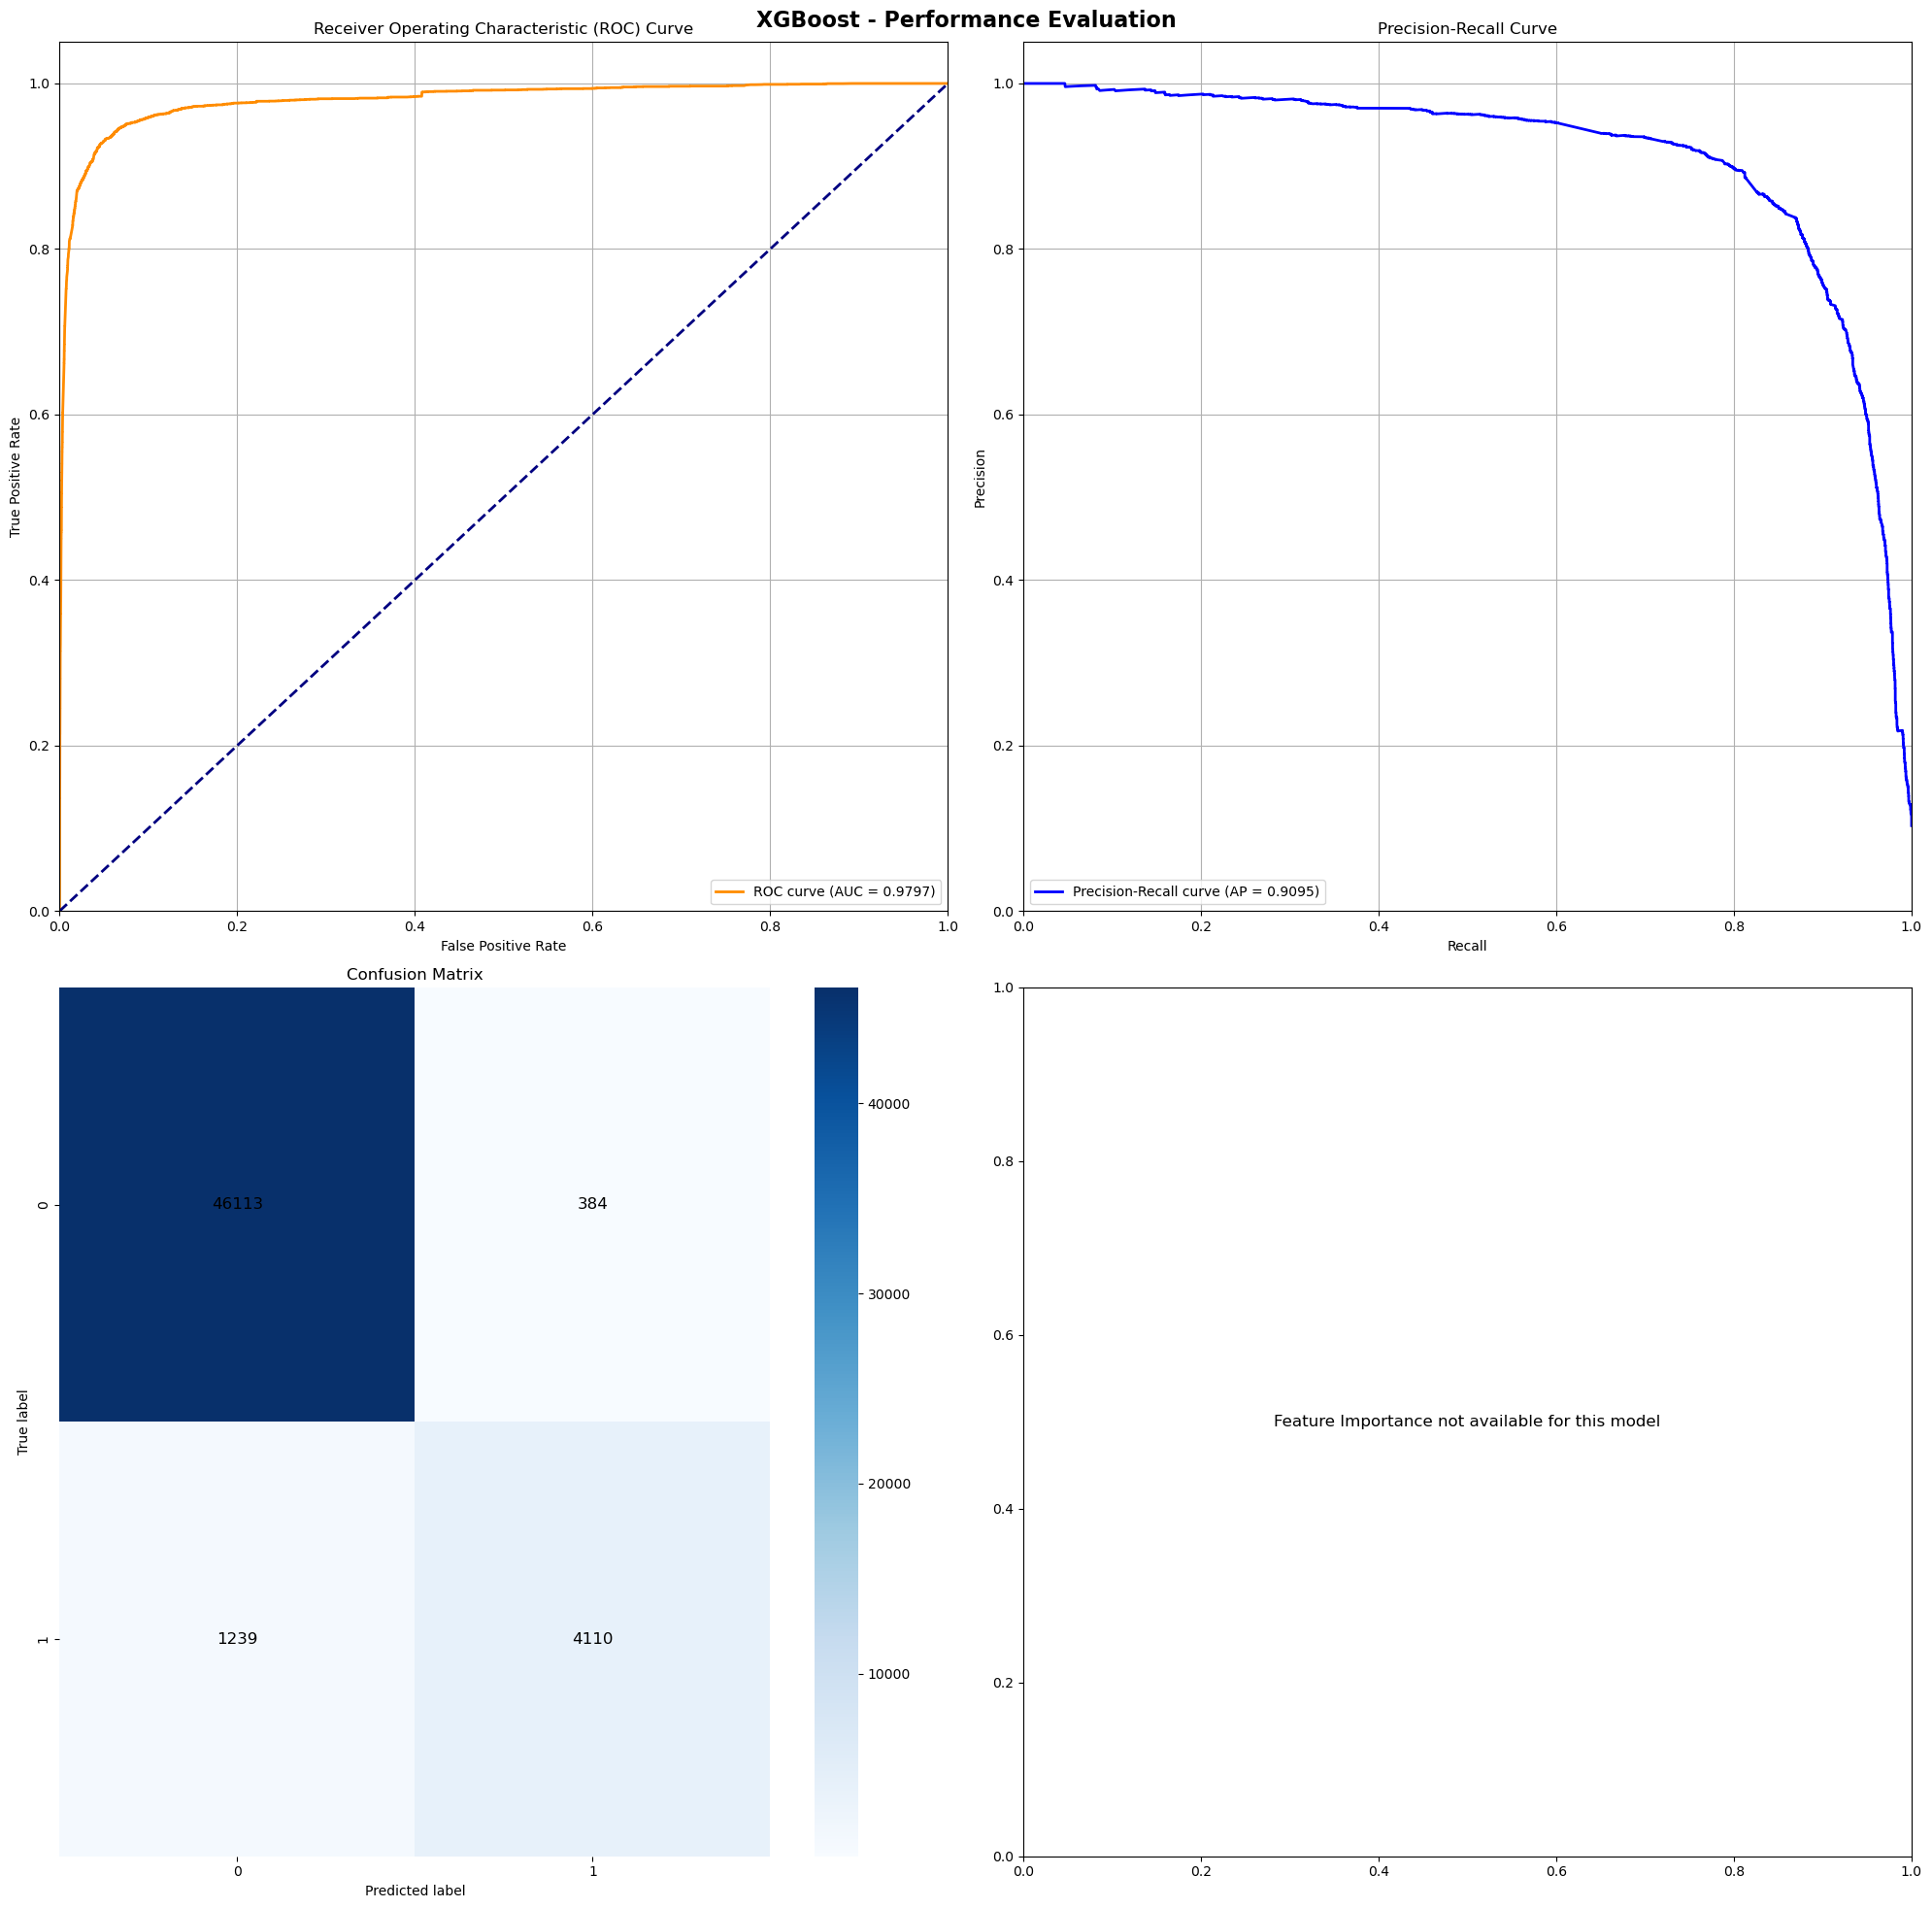


📌 Training Linear SVM
	🔹 X_train shape: (207384, 2657297)
	🔹 X_test shape: (51846, 2657297)
	🔹 y_train distribution: Counter({0: 186346, 1: 21038})
	🔹 y_test distribution: Counter({0: 46497, 1: 5349})


   ✅ Linear SVM Evaluation Metrics:
	🔹 Accuracy: 0.9788
	🔹 Precision: 0.9094
	🔹 Recall: 0.8822
	🔹 F1 Score: 0.8956
	🔹 ROC AUC: 0.9852
	🔹 Average Precision: 0.9417

   ✅ Confusion Matrix:
	🔹 TN: 46027, FP: 470
	🔹 FN: 630, TP: 4719



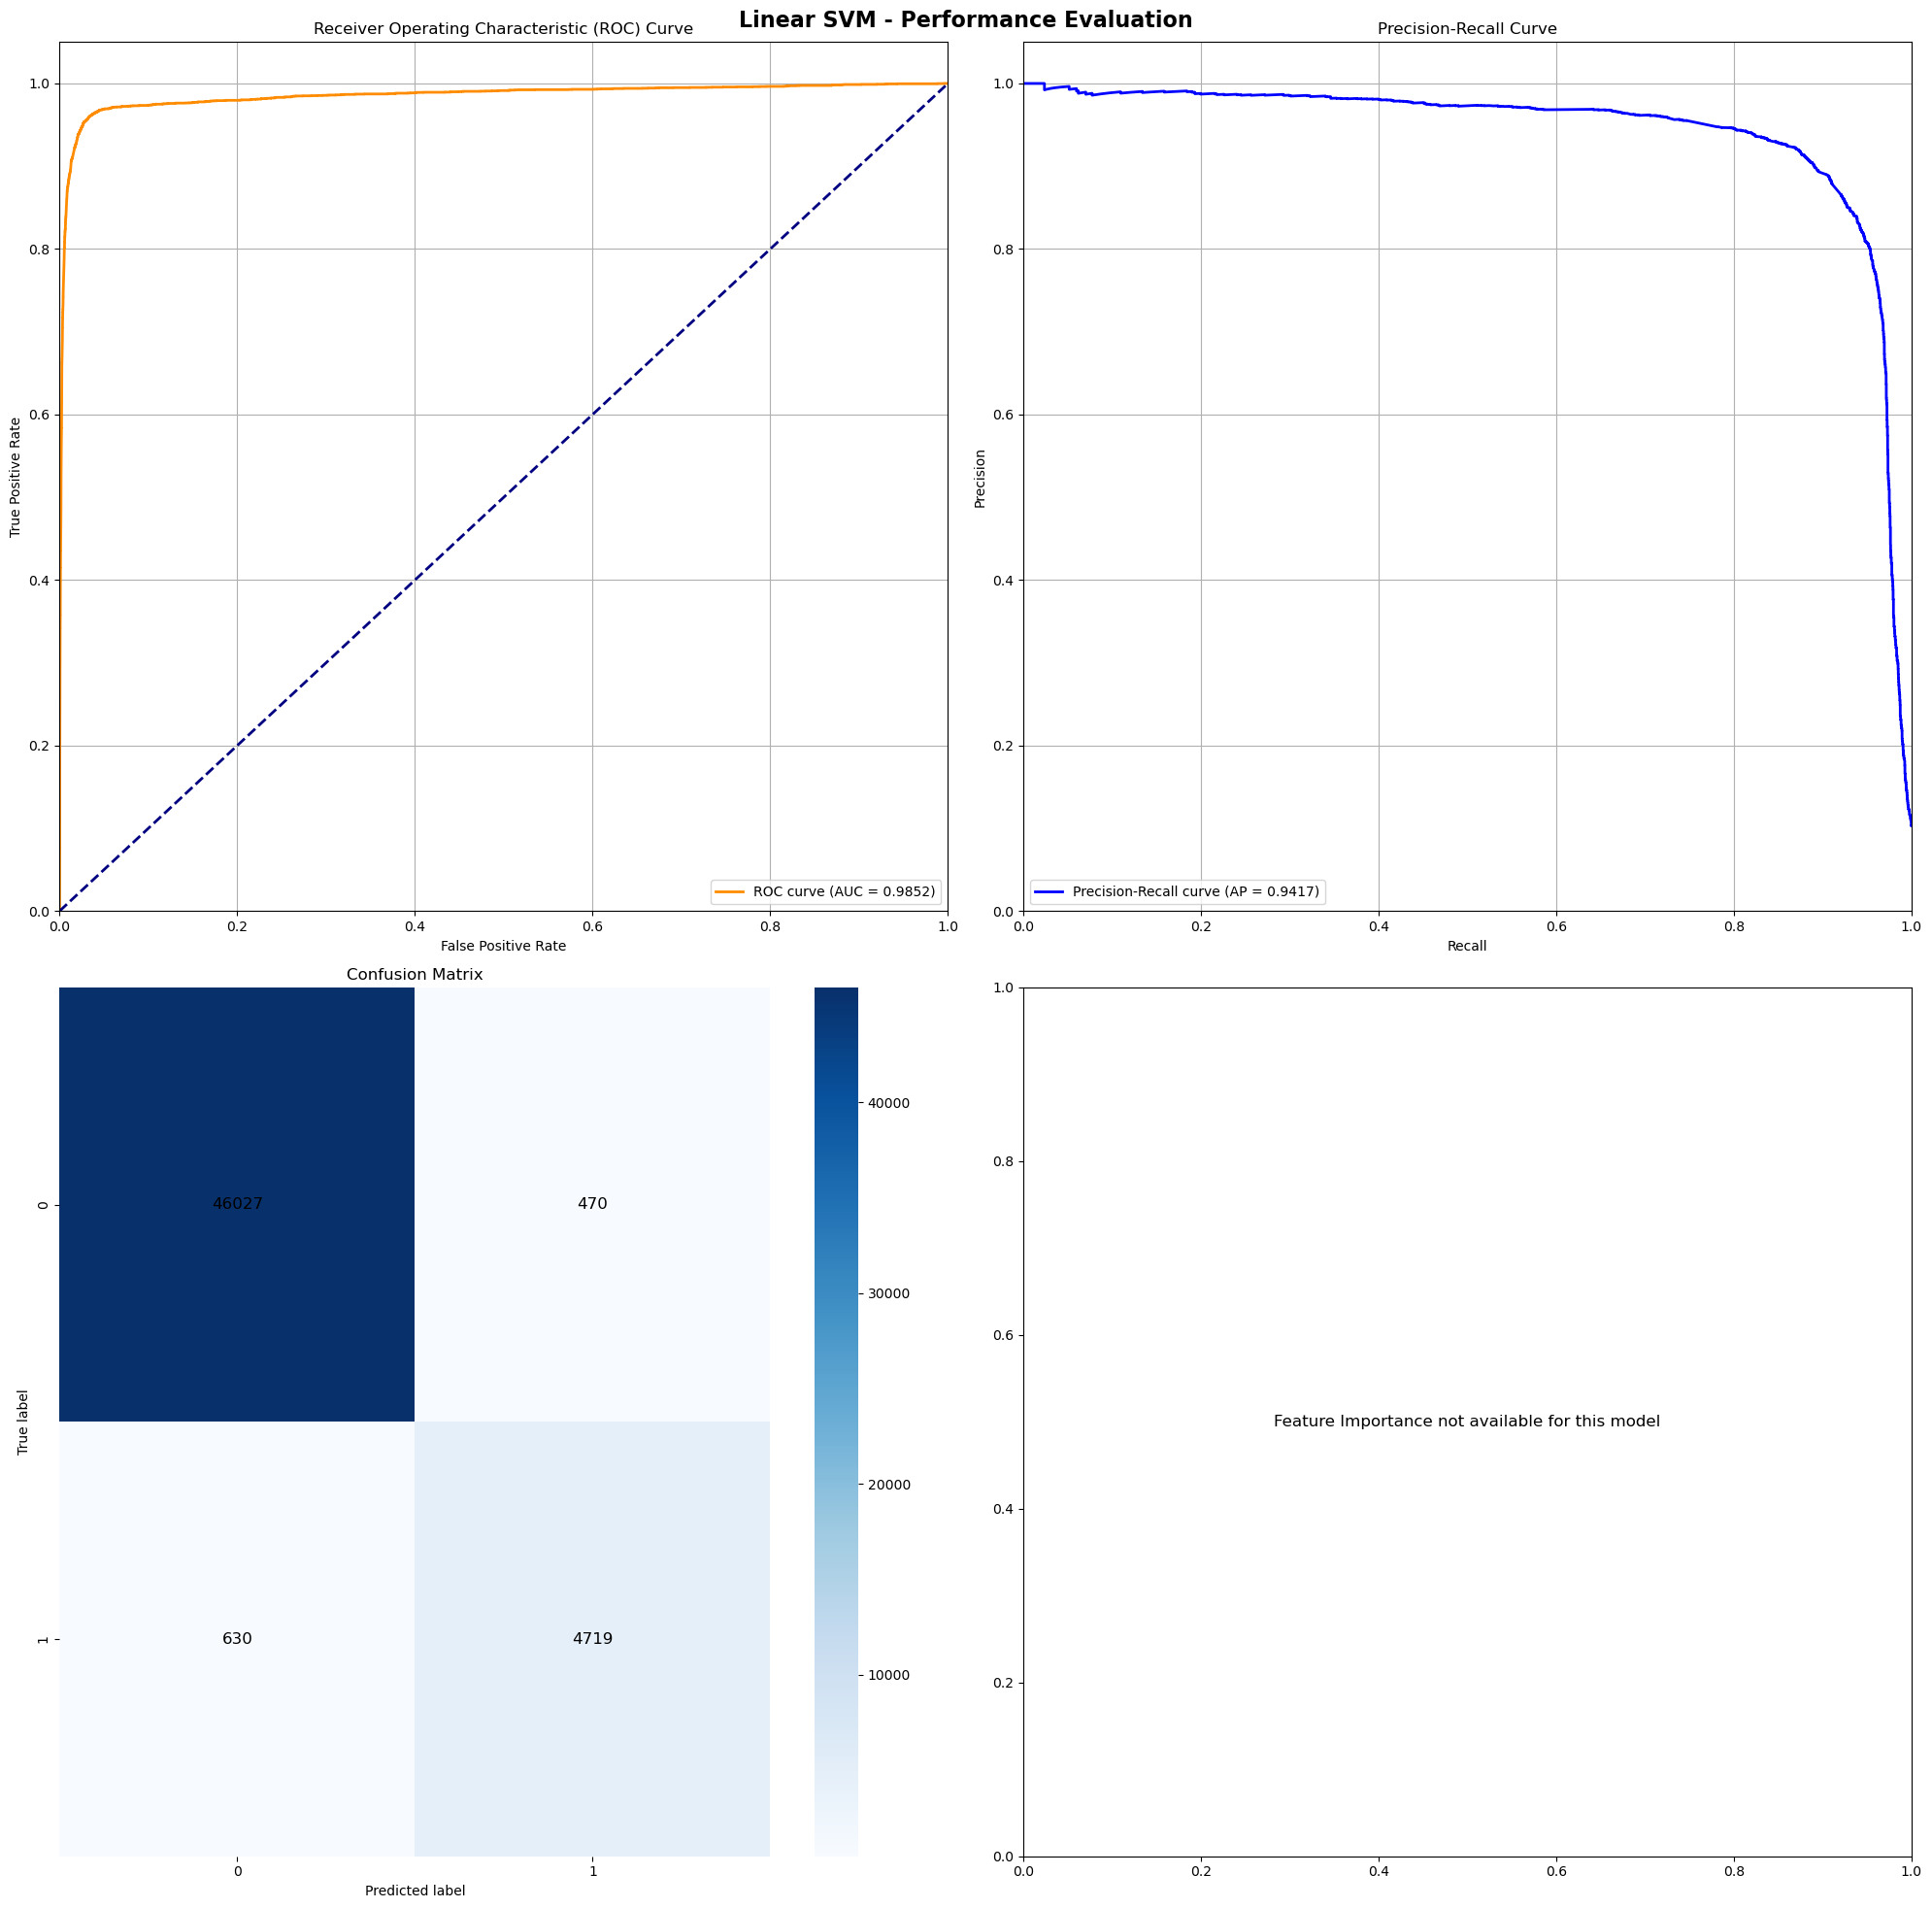

In [18]:
for model in models:
    model.train_and_evaluate_model(X_train, y_train, X_test, y_test)
    model.print_result()

# 2. **Verify which feature sets are most suitable for malware classification**

This involves identifying which data attributes (features) are most predictive of malware to enhance the classifier's performance.

## Feature Suitability for Malware Classification

- Use feature selection techniques like recursive feature elimination, feature importance from tree-based models, or L1 regularization to identify which features contribute most to the predictive power of the model.
- Conduct ablation studies where you systematically remove or add feature sets to see how performance is affected.
- Compare models trained on different subsets of features (e.g., API calls only, URL features only, combined features) to identify which sets or combinations are the most predictive.

### 2.2 Select features that start with 'api_calls::'

In [19]:
## Select features that start with 'api_calls::'
interest = "api_calls::"
selected_indices = [
    i
    for i, feature_name in enumerate(feature_names)
    if feature_name.startswith(interest)
]

selected_feature_names = feature_names[selected_indices]

# Select data with selected features
X_selected = X[:, selected_indices]

print(f"\n - Selected Features: {len(selected_indices)}")
for name in selected_feature_names:
    print(f"    🔹 {name}")


 - Selected Features: 314
    🔹 api_calls::android/accounts/AbstractAccountAuthenticator;->checkBinderPermission
    🔹 api_calls::android/accounts/AbstractAccountAuthenticator;->getAccountRemovalAllowed
    🔹 api_calls::android/accounts/AccountManager$AmsTask;->doWork
    🔹 api_calls::android/accounts/AccountManager;->addAccount
    🔹 api_calls::android/accounts/AccountManager;->addAccountExplicitly
    🔹 api_calls::android/accounts/AccountManager;->addOnAccountsUpdatedListener
    🔹 api_calls::android/accounts/AccountManager;->blockingGetAuthToken
    🔹 api_calls::android/accounts/AccountManager;->clearPassword
    🔹 api_calls::android/accounts/AccountManager;->confirmCredentials
    🔹 api_calls::android/accounts/AccountManager;->getAccounts
    🔹 api_calls::android/accounts/AccountManager;->getAuthToken
    🔹 api_calls::android/accounts/AccountManager;->getAuthTokenByFeatures
    🔹 api_calls::android/accounts/AccountManager;->getPassword
    🔹 api_calls::android/accounts/AccountMana

### 2.2 Check if each sample (row) has at least one selected feature

In [20]:
### Check if each sample (row) has at least one selected feature
# Sum across columns (axis=1) and check if greater than 0
selected_rows = np.where(X_selected.sum(axis=1) > 0)[0]

# Indices of samples that do not contain any of the selected features
removed_rows = np.setdiff1d(np.arange(X.shape[0]), selected_rows)

# Shape of the original data
print(f"\n - Original Data Shape: {X.shape}")

# Shape of the data with selected features
print(f" - Data with Selected Features Shape: {X_selected.shape}")

# Number of samples that do not contain any of the selected features
print(f" - Number of Removed Samples: {len(removed_rows)}")

# Shape of the data after removing samples without selected features
X_selected = X_selected[selected_rows]

print(f" - Data Shape After Removing Samples: {X_selected.shape}")


 - Original Data Shape: (259230, 2657297)
 - Data with Selected Features Shape: (259230, 314)
 - Number of Removed Samples: 2139
 - Data Shape After Removing Samples: (257091, 314)


In [21]:
# Select a subset of indices to check (first one for example)
subset_indices = removed_rows[:1]

# Function to print the features of specific samples in the original data
def print_original_sample_features(
    original_data, indices, selected_indices
):
    for idx in indices:
        print(f"\nOriginal Sample {idx}:")
        print(f"Selected Features: {original_data[idx, selected_indices].todense()}")

# Print features of a subset of removed samples in the original data
print("\nSubset of Removed Samples' Features in Original Data:")
print_original_sample_features(X, subset_indices, selected_indices)



Subset of Removed Samples' Features in Original Data:

Original Sample 5:
Selected Features: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0

### 2.3 Split data into training and testing sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y[selected_rows], test_size=0.2, random_state=42  # 80-20 split
)

print(f"\n - X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f" - X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")


 - X_train Shape: (205672, 314), y_train Shape: (205672,)
 - X_test Shape: (51419, 314), y_test Shape: (51419,)


### 2.4 Train and evaluate models

#### 2.4.1 Random Forest


📌 Training XGBoost
	🔹 X_train shape: (205672, 314)
	🔹 X_test shape: (51419, 314)
	🔹 y_train distribution: Counter({0: 185338, 1: 20334})
	🔹 y_test distribution: Counter({0: 46272, 1: 5147})


   ✅ XGBoost Evaluation Metrics:
	🔹 Accuracy: 0.9491
	🔹 Precision: 0.8988
	🔹 Recall: 0.5539
	🔹 F1 Score: 0.6854
	🔹 ROC AUC: 0.9385
	🔹 Average Precision: 0.7794

   ✅ Confusion Matrix:
	🔹 TN: 45951, FP: 321
	🔹 FN: 2296, TP: 2851



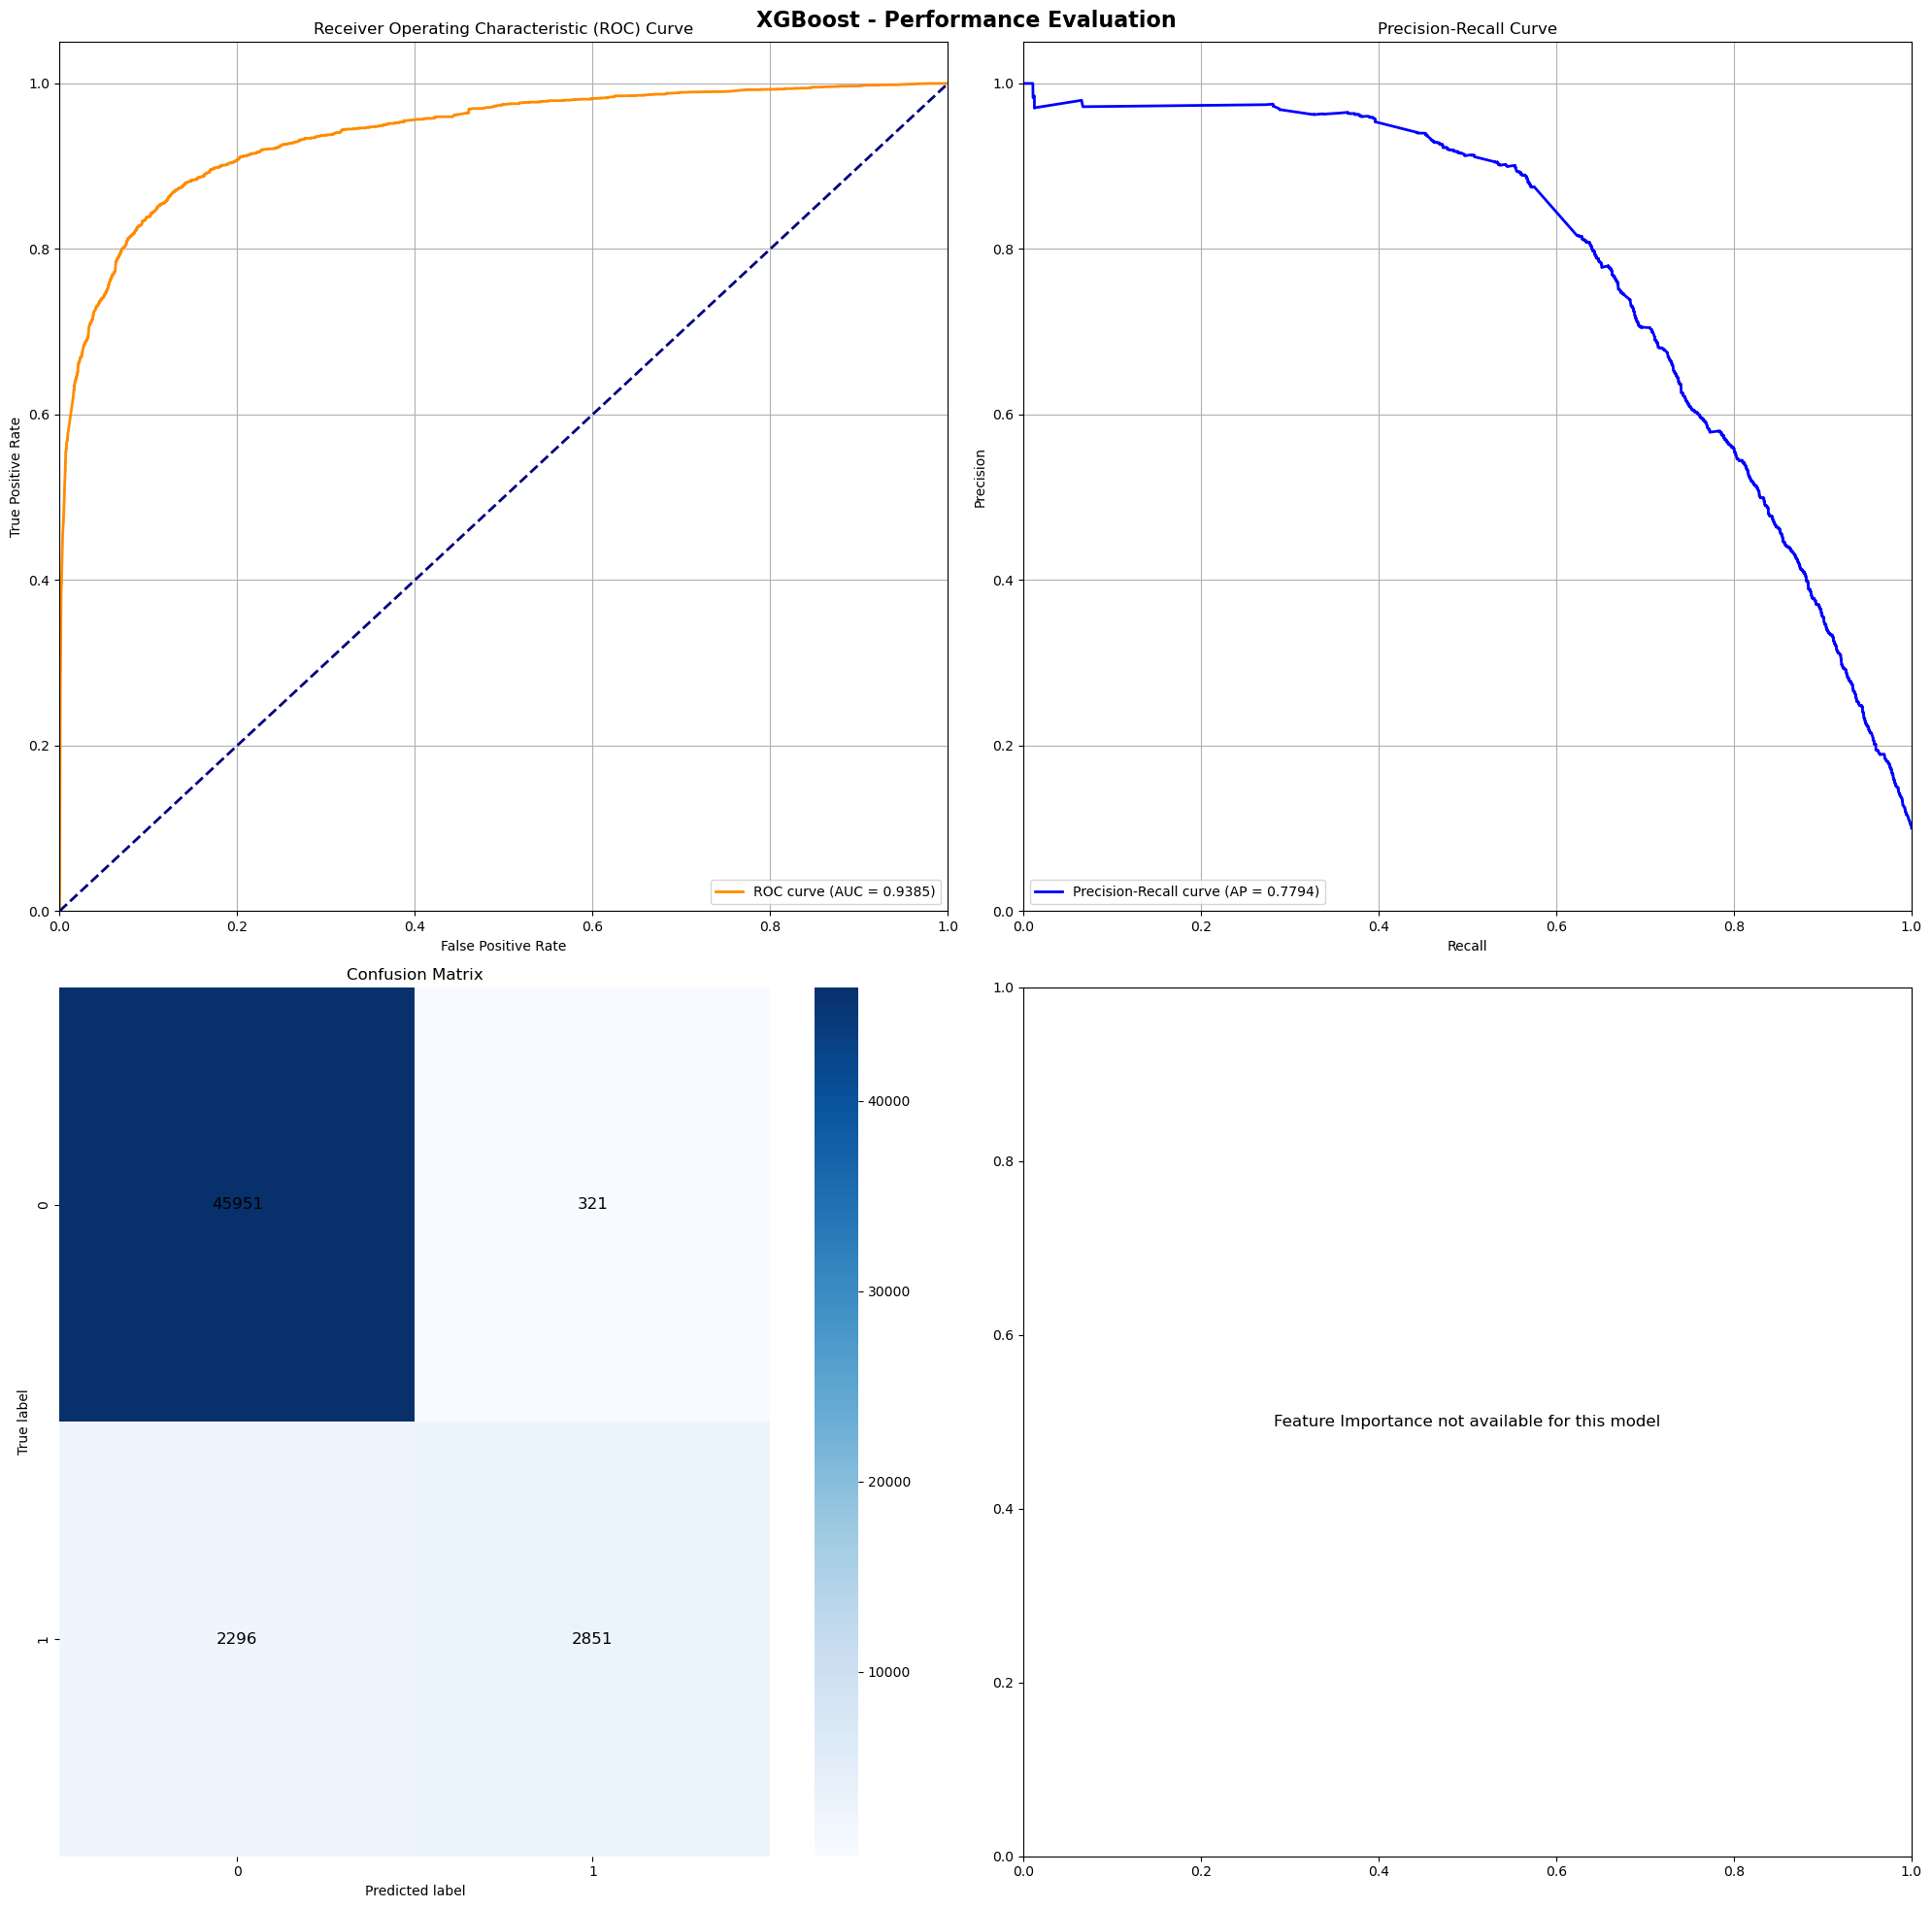


📌 Training Linear SVM
	🔹 X_train shape: (205672, 314)
	🔹 X_test shape: (51419, 314)
	🔹 y_train distribution: Counter({0: 185338, 1: 20334})
	🔹 y_test distribution: Counter({0: 46272, 1: 5147})


   ✅ Linear SVM Evaluation Metrics:
	🔹 Accuracy: 0.9320
	🔹 Precision: 0.8327
	🔹 Recall: 0.4012
	🔹 F1 Score: 0.5415
	🔹 ROC AUC: 0.8954
	🔹 Average Precision: 0.6703

   ✅ Confusion Matrix:
	🔹 TN: 45857, FP: 415
	🔹 FN: 3082, TP: 2065



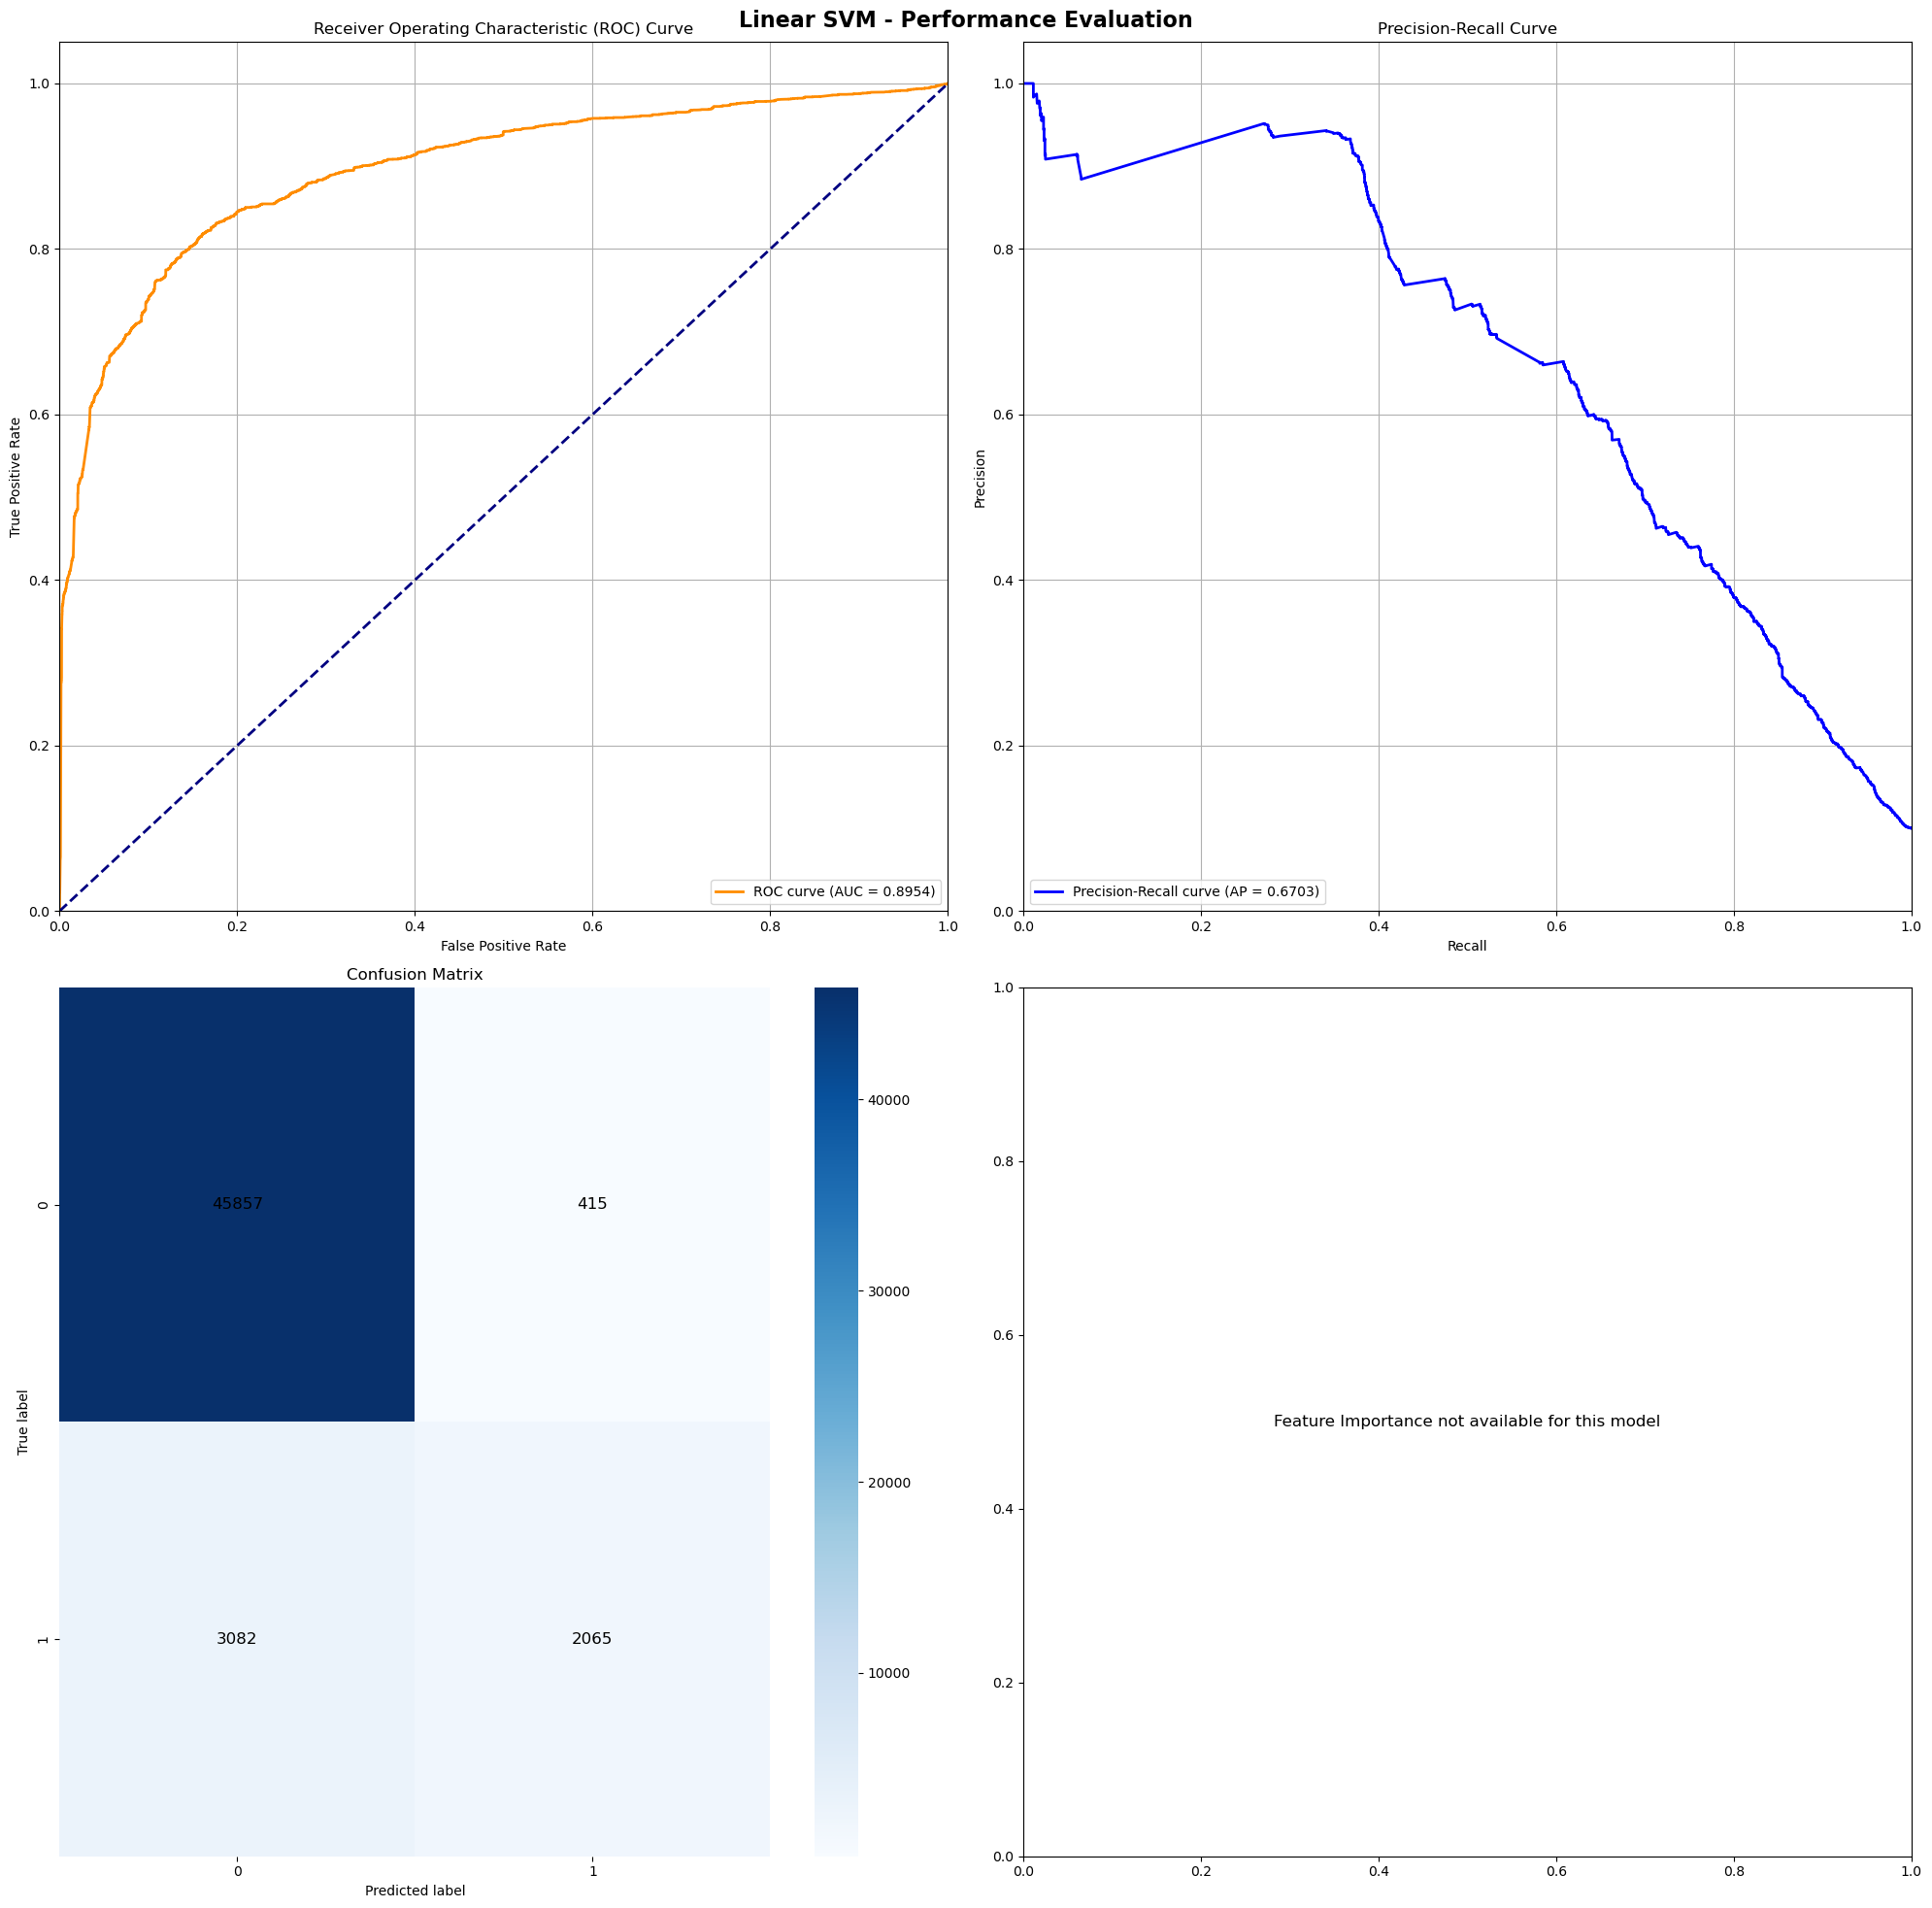

In [23]:
for model in models:
    model.train_and_evaluate_model(X_train, y_train, X_test, y_test)
    model.print_result()

### 2.5 Feature Importance

#### 6.1 Random Forest Feature Importance
- The higher the value, the more important the feature
- Normalize the values for better visualization

##### 6.1.1 Get the names of the top 10 most important features

In [30]:
# Ensure selected_feature_names is a NumPy array for easy indexing
selected_feature_names = np.array(selected_feature_names)

# Get feature importances from the trained Random Forest model
rf_feature_importances = random_forest_model.feature_importances_

# Normalize the values for better visualization
rf_feature_importances = 100.0 * (rf_feature_importances / rf_feature_importances.max())

# Get indices of the top 10 most important features
rf_top_indices = np.argsort(rf_feature_importances)[::-1][:10]

# Get the names of the top 10 most important features
rf_top_feature_names = selected_feature_names[rf_top_indices]


#### 6.1.2 Visualize Feature Importances

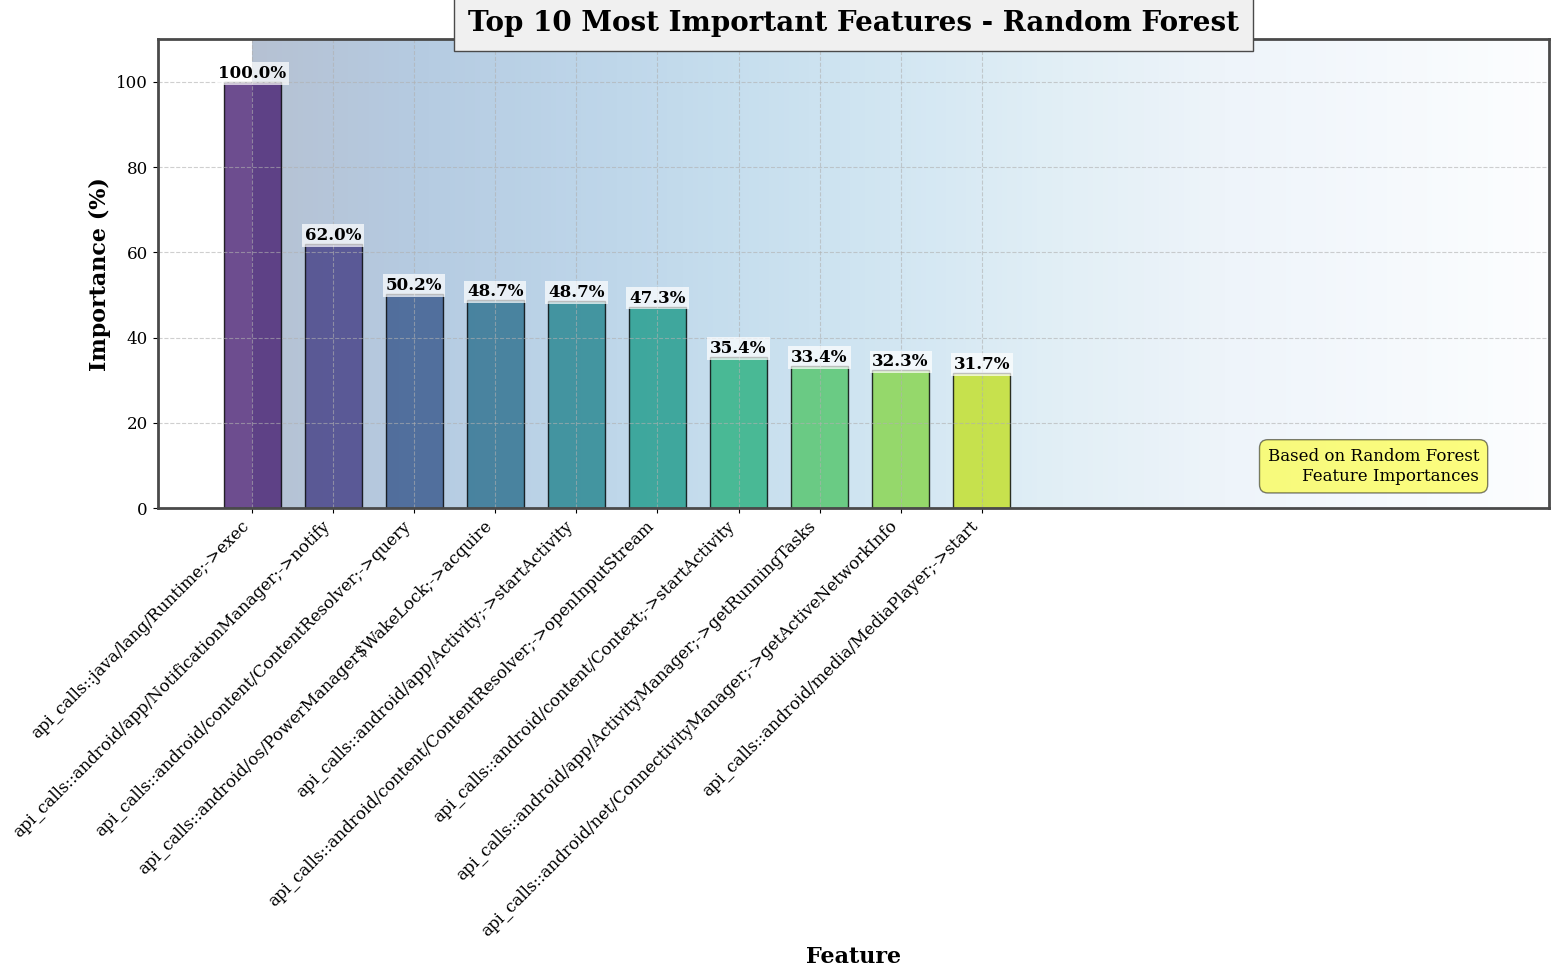

In [33]:
# Set figure size and font properties
plt.figure(figsize=(16, 10))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

# Create a gradient background
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(gradient, extent=[0, 16, 0, 110], aspect='auto', cmap='Blues_r', alpha=0.3)

# Plot the top 10 most important features
bars = plt.bar(
    rf_top_feature_names,
    rf_feature_importances[rf_top_indices],
    color=sns.color_palette("viridis", 10),
    edgecolor='black',
    align='center',
    width=0.7,
    alpha=0.8
)

# Add text annotations with improved styling
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold', 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2))

# Customize x and y axis
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Feature", fontsize=16, fontweight='bold')
plt.ylabel("Importance (%)", fontsize=16, fontweight='bold')

# Add a fancier title
plt.title("Top 10 Most Important Features - Random Forest", fontsize=20, fontweight='bold', 
          bbox=dict(facecolor='#f0f0f0', edgecolor='#4a4a4a', pad=10))

# Add a subtle grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add a border around the plot
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor("#4a4a4a")

# Add a legend-like box for extra information
plt.text(0.95, 0.05, "Based on Random Forest\nFeature Importances", transform=plt.gca().transAxes, 
         fontsize=12, va='bottom', ha='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('top_10_features_random_forest.png', format='png', dpi=300)

# Save the plot as a JPG file
plt.savefig('top_10_features_random_forest.jpg', format='jpg', dpi=300)

# Show the plot
plt.show()

#### 6.2 Linear SVM Feature Importance
- The higher the value, the more important the feature
- Normalize the values for better visualization

##### 6.2.1 Get the names of the top 10 most important features

In [36]:
# Use Seaborn for setting styles
sns.set_theme(style="darkgrid")

# Ensure selected_feature_names is a NumPy array for easy indexing
selected_feature_names = np.array(selected_feature_names)

# Get the coefficients of the Linear SVM model
svm_coefficients = np.abs(linear_svm_model.coef_)[0]

# Normalize the values for better visualization
svm_coefficients = 100.0 * (svm_coefficients / svm_coefficients.max())

# Get indices of the top 10 most important features
svm_top_indices = np.argsort(svm_coefficients)[::-1][:10]

# Get the names of the top 10 most important features
svm_top_feature_names = selected_feature_names[svm_top_indices]

#### 6.2.2 Visualize Feature Importances

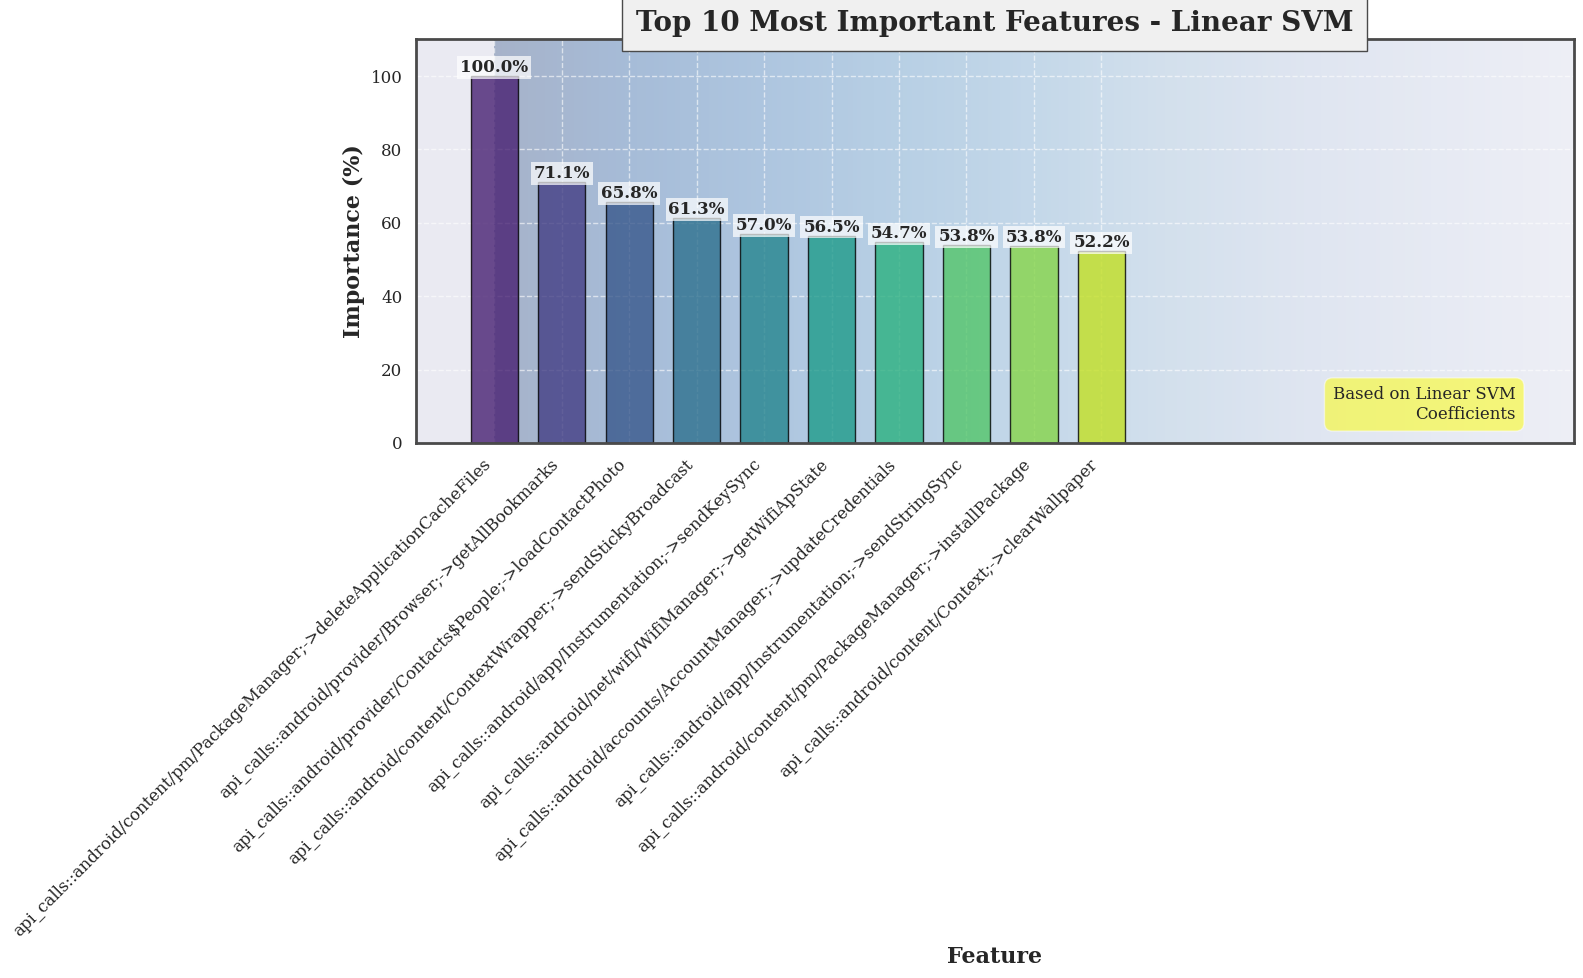

In [37]:
# Set figure size and font properties
plt.figure(figsize=(16, 10))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

# Create a gradient background
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(gradient, extent=[0, 16, 0, 110], aspect='auto', cmap='Blues_r', alpha=0.3)

# Plot the top 10 most important features
bars = plt.bar(
    svm_top_feature_names,
    svm_coefficients[svm_top_indices],
    color=sns.color_palette("viridis", 10),
    edgecolor='black',
    align='center',
    width=0.7,
    alpha=0.8
)

# Add text annotations with improved styling
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold', 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2))

# Customize x and y axis
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Feature", fontsize=16, fontweight='bold')
plt.ylabel("Importance (%)", fontsize=16, fontweight='bold')

# Add a fancier title
plt.title("Top 10 Most Important Features - Linear SVM", fontsize=20, fontweight='bold', 
          bbox=dict(facecolor='#f0f0f0', edgecolor='#4a4a4a', pad=10))

# Add a subtle grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add a border around the plot
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor("#4a4a4a")

# Add a legend-like box for extra information
plt.text(0.95, 0.05, "Based on Linear SVM\nCoefficients", transform=plt.gca().transAxes, 
         fontsize=12, va='bottom', ha='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('top_10_features_linear_svm.png', format='png', dpi=300)

# Save the plot as a JPG file
plt.savefig('top_10_features_linear_svm.jpg', format='jpg', dpi=300)

# Show the plot
plt.show()

# 3. **Explore how explanation methods can support the design and improvement of classification algorithms**

This points to the use of explanation methods, such as SHAP, to interpret ML models' decisions, possibly to increase their transparency and trustworthiness.

This project focuses on how existing explanation methods could support a better understanding of what the classifier is learning. A known problem in the literature is indeed "shortcut learning", i.e., learning information not related to actual maliciousness. For example, a network intrusion detection algorithm may be learning that "large volumes of outgoing bytes" are an attack, but this is clearly overfitting the task. Explanations methods to be explored include (see [2]): SHAP, LIME, LEMNA, LRP.


## Use of Explanation Methods to Support Model Design:

- Apply SHAP or LIME to your models to get explanations for individual predictions, which can provide insights into what features are driving the model’s decisions for each class.
- Use global feature importance derived from SHAP to understand overall model behavior and identify which features are generally most impactful across all predictions.
- Based on the insights from SHAP, iterate on your model design, potentially simplifying models by removing less important features or engineering new features to improve clarity and performance.


### 1. Prepare Samples

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y[selected_rows], test_size=0.2, random_state=42  # 80-20 split
)

print(f"\n - X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f" - X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")


 - X_train Shape: (205672, 314), y_train Shape: (205672,)
 - X_test Shape: (51419, 314), y_test Shape: (51419,)


 99%|===================| 50919/51419 [00:46<00:00]        

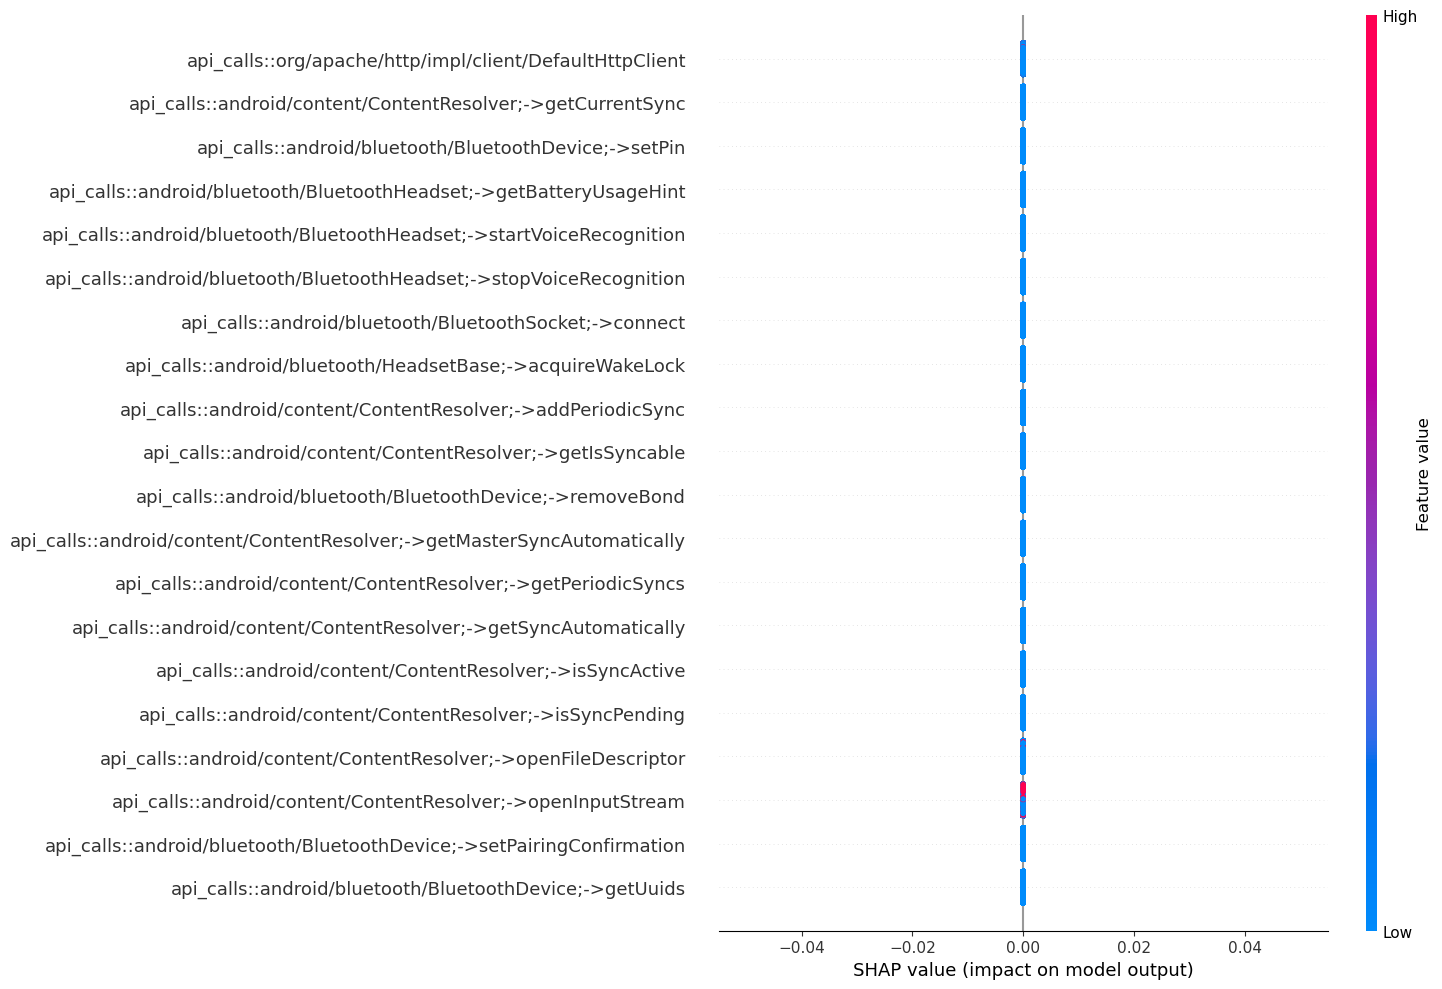

<Figure size 640x480 with 0 Axes>

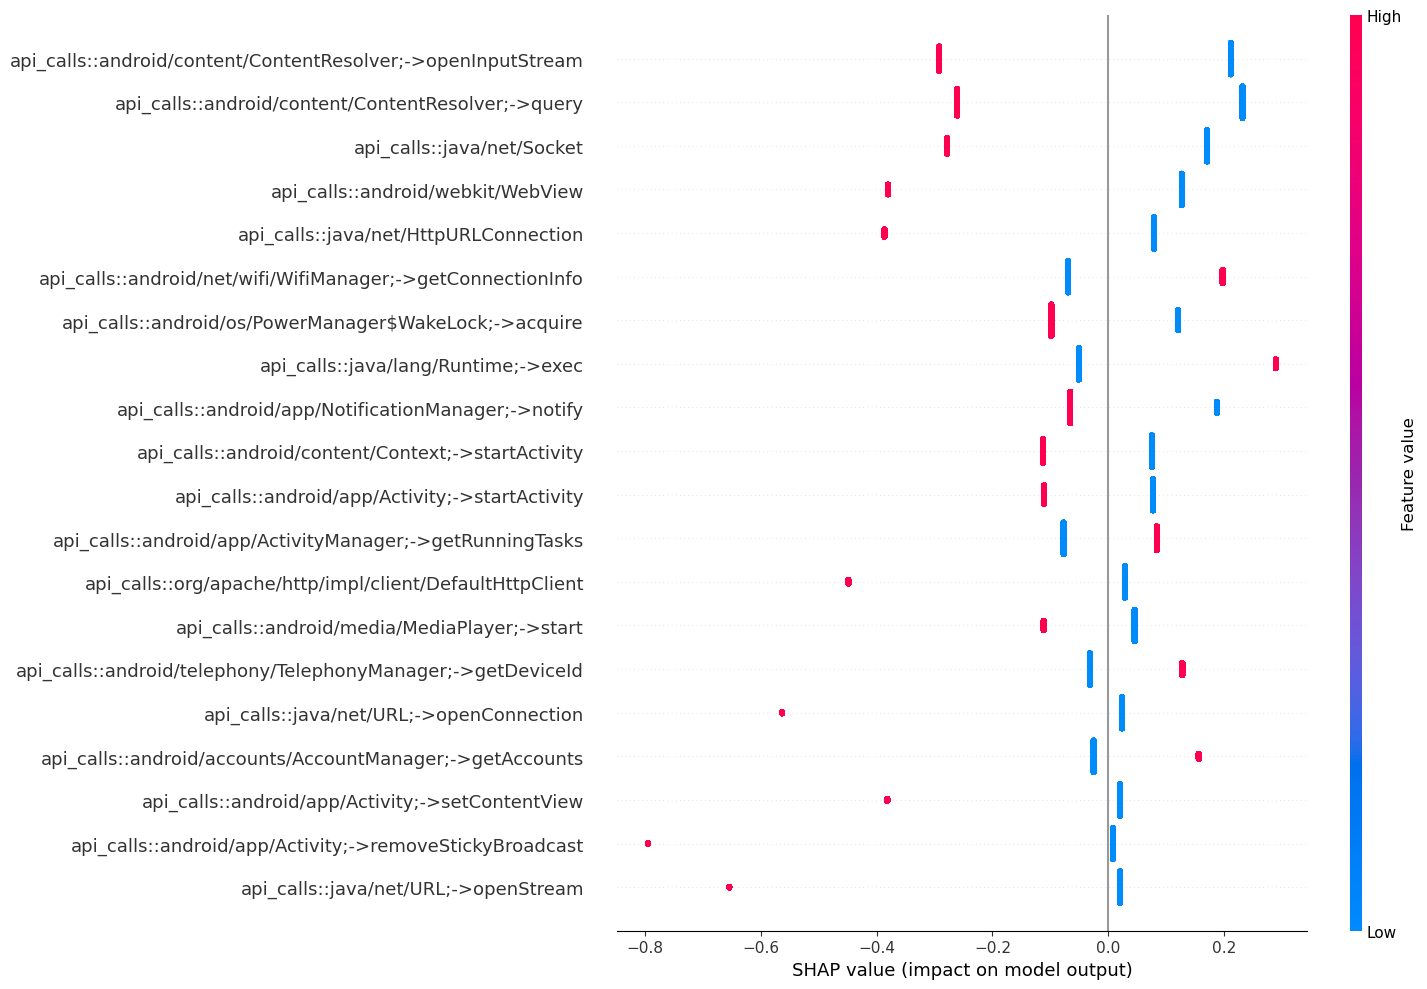

<Figure size 640x480 with 0 Axes>

In [25]:
import shap
import scipy.sparse

shap.initjs()

# Select 100 random background samples from the training data
background_sample_size = 500
background_samples = X_train[np.random.choice(X_train.shape[0], background_sample_size, replace=False)]

def compute_shap_values(model, background_samples, X_test):
    # Convert sparse matrices to dense format
    if scipy.sparse.issparse(background_samples):
        background_samples = background_samples.toarray()
    if scipy.sparse.issparse(X_test):
        X_test = X_test.toarray()
    
    explainer = shap.Explainer(model.model, background_samples)
    shap_values = explainer(X_test)
    return shap_values

def plot_shap_summary(shap_values, X_test, feature_names, model_name):
    plt.figure(figsize=(15, 10))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_size=(15, 10), color_bar=True)
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_shap_summary.png', dpi=300, bbox_inches='tight')
    plt.show()


for model in models:
    model.train_and_evaluate_model(X_train, y_train, X_test, y_test)

    # ! Convert X_test to dense array for plotting: Address sparse matrix issue (grey background)
    X_test_dense = X_test.toarray() if scipy.sparse.issparse(X_test) else X_test
    
    # Compute SHAP values
    shap_values = compute_shap_values(model, background_samples, X_test)
    
    # Plot SHAP summary
    plot_shap_summary(shap_values, X_test_dense, selected_feature_names, model.name)